# Исследование поведения пользователей приложения по продаже продуктов питания

## **Шаг 1. Подготовка данных**

Вызовем все библиотеки, которые могут понадобиться для выполнения проекта:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as st
import math as mth

Откроем файл с данными и изучим общую информацию:

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


На первый взгляд явных проблем с данными нет. По крайней мере, пропуски отсутствуют, и типы данных не требуют замены.
Для дальнейшей работы нам потребуется сделать следующее:

1. Переименовать столбцы.
2. Добавить столбец даты и времени, а также отдельный столбец дат.
3. Проверить на наличие дубликатов.

In [5]:
data.columns = ['event', 'user_id', 'event_ts', 'group']
data.head()

,event,user_id,event_ts,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Столбцы переименовали. Можно двигаться дальше.

In [6]:
data['dt'] = pd.to_datetime(data['event_ts'], unit='s') # перевели данные из столбца "event_ts" в дату и время
data['date'] = data['dt'].dt.date # выделили из данных из столбца dt только дату
data.head()

,event,user_id,event_ts,group,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     244126 non-null  object        
 1   user_id   244126 non-null  int64         
 2   event_ts  244126 non-null  int64         
 3   group     244126 non-null  int64         
 4   dt        244126 non-null  datetime64[ns]
 5   date      244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


В столбце "date" данные нужно привести к формату datetime:

In [8]:
data['date'] = data['date'].astype('datetime64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     244126 non-null  object        
 1   user_id   244126 non-null  int64         
 2   event_ts  244126 non-null  int64         
 3   group     244126 non-null  int64         
 4   dt        244126 non-null  datetime64[ns]
 5   date      244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Осталось провести проверку на наличие дубликатов:

In [9]:
num_of_dub = data.duplicated().sum()
num_of_dub

413

In [10]:
dub_ratio = num_of_dub/len(data['user_id'])*100
dub_ratio.round(2)

0.17

В нашем датасете мы имеем 413 дубликатов, что составляет всего примерно 0,17 % от всех данных. Их можно безболезненно удалить.

In [11]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   user_id   243713 non-null  int64         
 2   event_ts  243713 non-null  int64         
 3   group     243713 non-null  int64         
 4   dt        243713 non-null  datetime64[ns]
 5   date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [12]:
data

,event,user_id,event_ts,group,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


**Вывод по шагу 1:**

На данном шаге была произведена предобработка изучаемых данных:
* переименованы столбцы;
* добавлены столбцы с датой и временем, а также отдельно с датой;
* проведена проверка на наличие дубликатов, с последующим их удалением.

На следующем шаге изучим таблицу более подробно.

## **Шаг 2. Изучение и проверка данных**

На данном шаге нужно будет выполнить следующие действия:

* посмотреть, сколько всего событий, пользователей в логе, и сколько в среднем событий приходится на одного пользователя;
* определить, данными за какой период времени мы располагаем;
* изучить, насколько полные данные мы имеем и как они распределены по времени;
* окончательно подготовить данные для проведения A/A/B-теста.

Начнем с определения количества событий в логе:

In [13]:
data['event'].nunique()

5

В логе мы имеем 5 уникальных событий. Посмотрим, как они распределены количественно:

In [14]:
data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Теперь посмотрим, сколько всего пользователей в логе, и как они распределены по группам:

In [15]:
data['user_id'].nunique()

7551

In [16]:
data['group'].unique()

array([246, 248, 247])

Всего 7551 пользователь. Все пользователи распределены по 3 группам. Посмотрим, как они распределены:

In [17]:
a1 = data.loc[data['group']==246]['user_id'].nunique()
a2 = data.loc[data['group']==247]['user_id'].nunique()
b = data.loc[data['group']==248]['user_id'].nunique()
print('В группе 246 - ', a1, 'пользователей.')
print('В группе 247 - ', a2, 'пользователей.')
print('В группе 248 - ', b, 'пользователя.')

В группе 246 -  2489 пользователей.
В группе 247 -  2520 пользователей.
В группе 248 -  2542 пользователя.


На всякий случай убедимся, что в сумме получится общее число уникальных пользователей:

In [18]:
sum = a1 + a2 + b
sum

7551

Все верно. Таким образом все пользователи распределены по 3 группам.

Теперь определим, сколько событий в среднем приходится на одного пользователя. Для этого разделим общее число событий на общее число уникальных пользователей:

In [19]:
mean_events = len(data['event'])/sum
print('Среднее количество событий на одного пользователя:', "{0:.2f}".format(mean_events))

Среднее количество событий на одного пользователя: 32.28


Далее можно определить, за какой период времени у нас имеются данные:

In [20]:
min_date = data['date'].min()
max_date = data['date'].max()
print('Имеются данные с', min_date, 'по', max_date)

Имеются данные с 2019-07-25 00:00:00 по 2019-08-07 00:00:00


Таким образом мы имеем данные с 25 июля по 7 августа (т.е. за 14 дней)

Определим, как распределены события во времени. Для этого построим гистограмму:

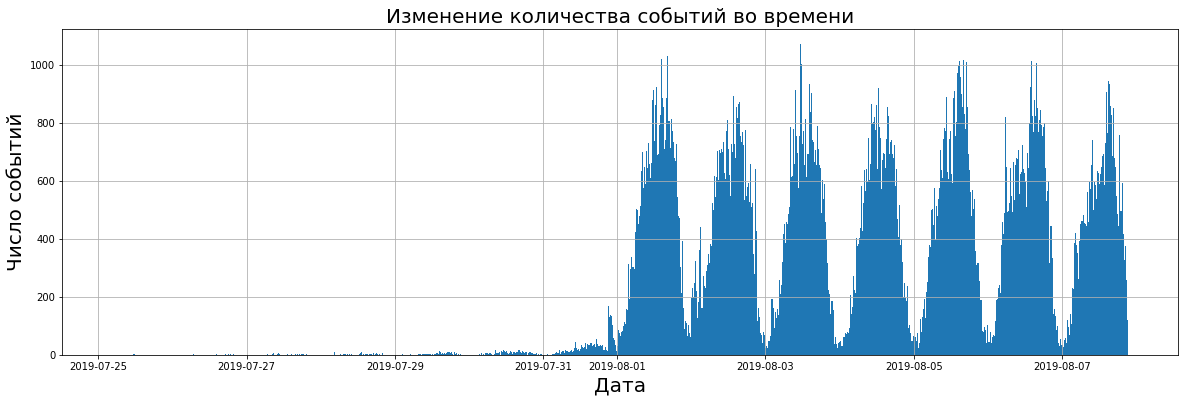

In [55]:
data['dt'].hist(figsize=(20,6), bins=1000)
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Число событий', fontsize=20)
plt.title('Изменение количества событий во времени', fontsize=20)
plt.show()

Посмотрим, на численное распределение событий по датам:

In [22]:
events_by_day = data.groupby('date')['event'].count()
events_by_day

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event, dtype: int64

Как видно по гистограмме, а также по численным значениям, основные события стали происходить с 1 августа 2019 года. Поэтому все данные, которые были получены ранее этой даты можно удалить.

In [23]:
data_clear = data.loc[data['dt'] >= '2019-08-01'].reset_index(drop=True)
data_clear

,event,user_id,event_ts,group,dt,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
240883,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
240884,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
240885,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


<div class="alert alert-block alert-success"><b>Комментарий ревьюера</b>
    
<b>Успех:</b><br>
    👍 Период выбран правильно. 
</div>

Посчитаем, сколько событий и пользователей мы потеряли, "обрезав" данные:

In [24]:
data_clear['event'].count()

240887

In [25]:
data_clear['user_id'].nunique()

7534

In [26]:
lost_events = ((data['event'].count()-data_clear['event'].count())/data['event'].count()*100).round(2) 
print('После удаления данных потеряно', lost_events, '% событий')

После удаления данных потеряно 1.16 % событий


In [27]:
lost_users = ((data['user_id'].nunique()-data_clear['user_id'].nunique())/data['user_id'].nunique()*100)
print('После удаления данных потеряно', "{0:.2f}".format(lost_users), '% пользователей')

После удаления данных потеряно 0.23 % пользователей


Как видно выше, "обрезка" данных не привела к значительному уменьшению количества событий и пользователей.

Убедимся, что в исследуемых группах не произошло значительных изменений:

In [28]:
a1_clear = data_clear.loc[data_clear['group']==246]['user_id'].nunique()
a2_clear = data_clear.loc[data_clear['group']==247]['user_id'].nunique()
b_clear = data_clear.loc[data_clear['group']==248]['user_id'].nunique()
print('В группе 246 - ', a1_clear, 'пользователя.')
print('В группе 247 - ', a2_clear, 'пользователей.')
print('В группе 248 - ', b_clear, 'пользователей.')

В группе 246 -  2484 пользователя.
В группе 247 -  2513 пользователей.
В группе 248 -  2537 пользователей.


In [29]:
lost_a1 = (a1 - a1_clear)/a1*100
lost_a2 = (a2 - a2_clear)/a1*100
lost_b = (b - b_clear)/a1*100
print('После удаления данных в группе 246 потеряно', "{0:.2f}".format(lost_a1), '% пользователей')
print('После удаления данных в группе 247 потеряно', "{0:.2f}".format(lost_a2), '% пользователей')
print('После удаления данных в группе 248 потеряно', "{0:.2f}".format(lost_b), '% пользователей')

После удаления данных в группе 246 потеряно 0.20 % пользователей
После удаления данных в группе 247 потеряно 0.28 % пользователей
После удаления данных в группе 248 потеряно 0.20 % пользователей


Как видно выше, во всех исследуемых группах количество пользователей уменьшилось незначительно.

**Вывод по шагу 2.**

На данном шаге были получены следующие результаты:

1. Определено количество событий в логе: уникальных событий - 5.
2. Количество уникальных пользователей - 7551.
3. В среднем на одного пользователя приходится 32.28 событий.
4. В датасете представлены данные с 25 июля по 7 августа 2019 года.
5. Выявлено, что основные события происходили с 1 августа 2019 года, поэтому было решено удалить данные за более ранний период времени.
6. После удаления "старых" данных было потеряно всего 1.16 % событий и примерно 0.23 % уникальных пользователей, что не критично для проведения дальнейшего анализа.
7. **Количество участников в группах сбалансировано.**

## Шаг 3. Изучение воронки продаж

На данном шаге необходимо выяснить следующее:
* как пользователи доходят до покупки;
* сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах;
* на каких именно шагах это происходит?

Для того чтобы выяснить, как пользователи доходят до покупки изучим события, которые есть в логах. На шаге 2 мы уже выдели, как распределены события в логах численно, но делали это для всего датасета. Поэтому рассмотрим распределение уже в "очищенном" датасете:

In [30]:
events_distribution = data_clear['event'].value_counts()
events_distribution

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

Предположим, в каком порядке события расположены:

1. **MainScreenAppear** - появление главного экрана;
2. **OffersScreenAppear** - появление экрана с предложениями;
3. **CartScreenAppear** - появление экрана с корзиной;
4. **PaymentScreenSuccessful** - экран с подтверждением успешной покупки.

Событие **Tutorial** (руководство либо инструкция для пользователя) может происходить когда-угодно. Оно никак не должно влиять на переход от одного события к другому.

Визуализируем распределение событий:

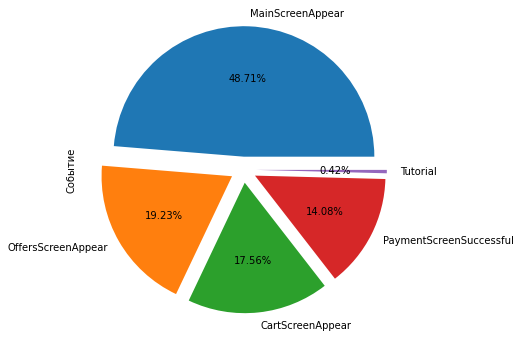

In [31]:
events_distribution.plot(kind='pie', figsize=(15,6), label = 'Событие', explode = (0.1, 0.1, 0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.show()

Как видно выше, самое частое событие - **"Появление главного экрана"**. На него приходится 48.71 % от всех событий. После него идут **"Появление экрана с предложениями"** - 19.23 %, **"Появление экрана с корзиной"** - 17.56 % и **"Появление экрана с подтверждением успешной покупки"** - 14.08 %. Событие **Tutorial** - самое редкое (около 0.42 % от всех событий).

Теперь рассмотрим сколько пользователей "прошли" через каждое событие. Рассматривать будем как общее количество пользователей, так и с разбиением по исследуемым группам.

In [32]:
user_events = data_clear.pivot_table(index='event', values='user_id', aggfunc='nunique')
user_events.columns = ['total_users']
user_events.sort_values(by='total_users', ascending=False)

,total_users
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [33]:
user_events_a1 = data_clear.loc[data_clear['group']==246].pivot_table(index='event', values='user_id', aggfunc='nunique')
user_events_a1.columns = ['users_a1']
user_events_a1.sort_values(by='users_a1', ascending=False)

,users_a1
event,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


In [34]:
user_events_a2 = data_clear.loc[data_clear['group']==247].pivot_table(index='event', values='user_id', aggfunc='nunique')
user_events_a2.columns = ['users_a2']
user_events_a2.sort_values(by='users_a2', ascending=False)

,users_a2
event,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


In [35]:
user_events_b = data_clear.loc[data_clear['group']==248].pivot_table(index='event', values='user_id', aggfunc='nunique')
user_events_b.columns = ['users_b']
user_events_b.sort_values(by='users_b', ascending=False)

,users_b
event,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181
Tutorial,279


In [36]:
events_by_users = (user_events.merge(user_events_a1, left_on='event', right_on='event', how='left').
                   merge(user_events_a2, left_on='event', right_on='event', how='left').
                   merge(user_events_b, left_on='event', right_on='event', how='left')).sort_values(by='total_users', ascending=False)
events_by_users['event_short'] = ['Main', 'Offers', 'Cart', 'Payment', 'Tutorial'] # ввел короткие названия для удобства
events_by_users

,total_users,users_a1,users_a2,users_b,event_short
event,,,,,
MainScreenAppear,7419,2450,2476,2493,Main
OffersScreenAppear,4593,1542,1520,1531,Offers
CartScreenAppear,3734,1266,1238,1230,Cart
PaymentScreenSuccessful,3539,1200,1158,1181,Payment
Tutorial,840,278,283,279,Tutorial


Общую таблицу подготовили. По численным значениям видно, что события примерно одинаково распределены между пользователями из разных групп. Однако для большей наглядности визуализируем данные из таблицы:

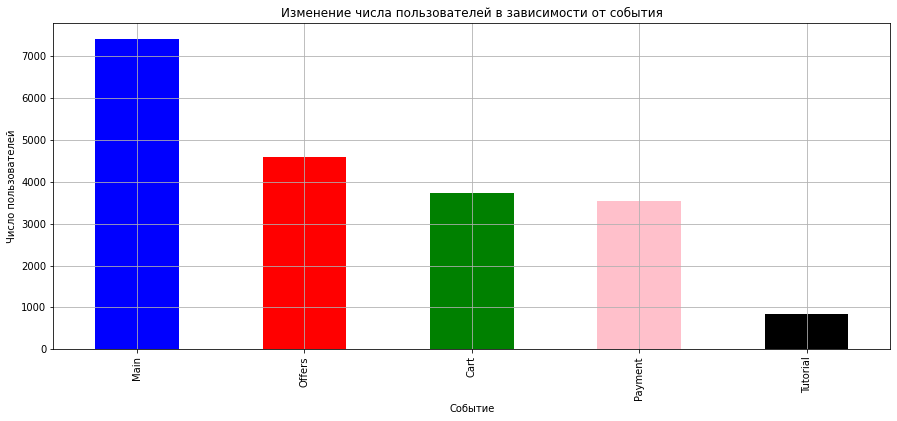

In [37]:
# визуализация для общего числа пользователей
events_by_users.plot(x='event_short',
                     y='total_users',
                     kind='bar',
                     figsize=(15,6),
                     grid=True,
                     color = ['blue', 'red', 'green', 'pink', 'black'],
                     title = 'Изменение числа пользователей в зависимости от события',
                    legend=False)
plt.xlabel('Событие')
plt.ylabel('Число пользователей')
plt.show()

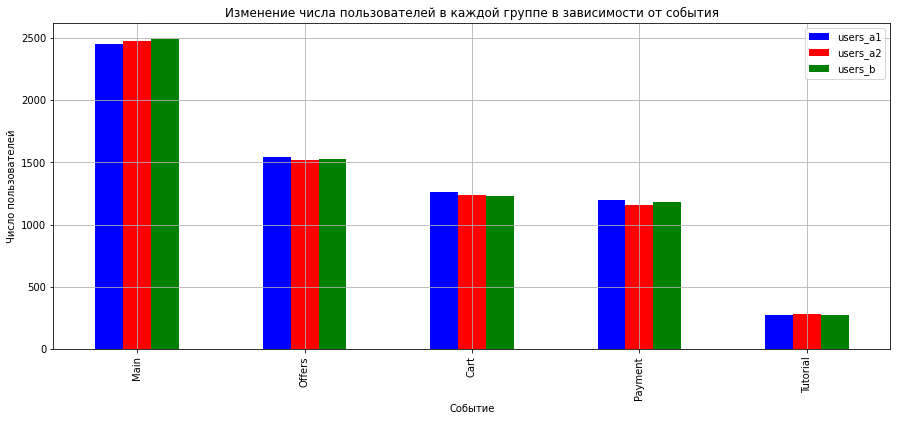

In [38]:
# визуализация отдельно по группам
events_by_users.plot(x='event_short',
                     y=['users_a1', 'users_a2', 'users_b'],
                     kind='bar',
                     figsize=(15,6),
                     grid=True,
                     color = ['blue', 'red', 'green'],
                     title = 'Изменение числа пользователей в каждой группе в зависимости от события',
                    legend=True)
plt.xlabel('Событие')
plt.ylabel('Число пользователей')
plt.show()

Как видно из рисунков, количество пользователей, совершивших событие **"Появление главного экрана"** - максимально. После него идут **"Появление экрана с предложениями"**, **"Появление экрана с корзиной"** и **"Появление экрана с подтверждением успешной покупки"**. Событие **Tutorial** снова самое редкое. Т.е. картина схожа с той, что мы видели для распределения событий.

Дополнительно еще рассмотрим доли от общего числа пользователей, которые хотя бы раз совершили определенное событие.

In [39]:
events_by_users['total_part'] = events_by_users['total_users']/data_clear['user_id'].nunique()*100
events_by_users['total_part'] = events_by_users['total_part'].astype('float').round(2)
events_by_users['users_a1_part'] = events_by_users['users_a1']/a1_clear*100
events_by_users['users_a1_part'] = events_by_users['users_a1_part'].astype('float').round(2)
events_by_users['users_a2_part'] = events_by_users['users_a2']/a2_clear*100
events_by_users['users_a2_part'] = events_by_users['users_a2_part'].astype('float').round(2)
events_by_users['users_b_part'] = events_by_users['users_b']/b_clear*100
events_by_users['users_b_part'] = events_by_users['users_b_part'].astype('float').round(2)
events_by_users=events_by_users.reset_index()
events_by_users

,event,total_users,users_a1,users_a2,users_b,event_short,total_part,users_a1_part,users_a2_part,users_b_part
0,MainScreenAppear,7419,2450,2476,2493,Main,98.47,98.63,98.53,98.27
1,OffersScreenAppear,4593,1542,1520,1531,Offers,60.96,62.08,60.49,60.35
2,CartScreenAppear,3734,1266,1238,1230,Cart,49.56,50.97,49.26,48.48
3,PaymentScreenSuccessful,3539,1200,1158,1181,Payment,46.97,48.31,46.08,46.55
4,Tutorial,840,278,283,279,Tutorial,11.15,11.19,11.26,11.00


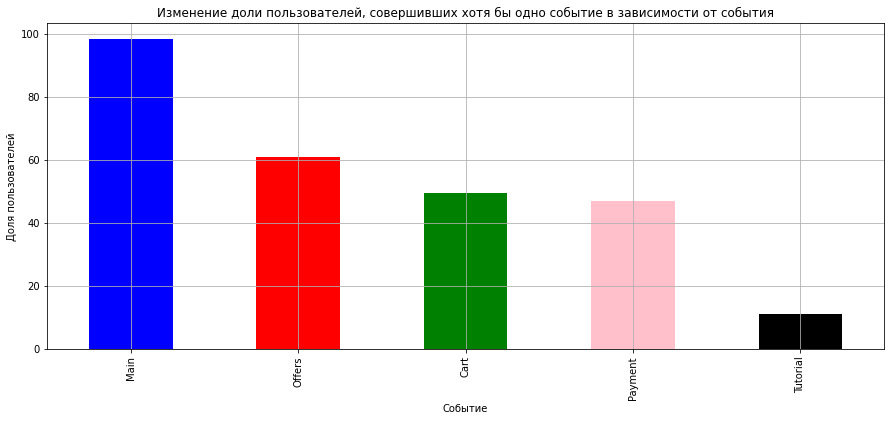

In [40]:
# визуализация для общего числа пользователей
events_by_users.plot(x='event_short',
                     y='total_part',
                     kind='bar',
                     figsize=(15,6),
                     grid=True,
                     color = ['blue', 'red', 'green', 'pink', 'black'],
                     title = 'Изменение доли пользователей, совершивших хотя бы одно событие в зависимости от события',
                    legend=False)
plt.xlabel('Событие')
plt.ylabel('Доля пользователей')
plt.show()

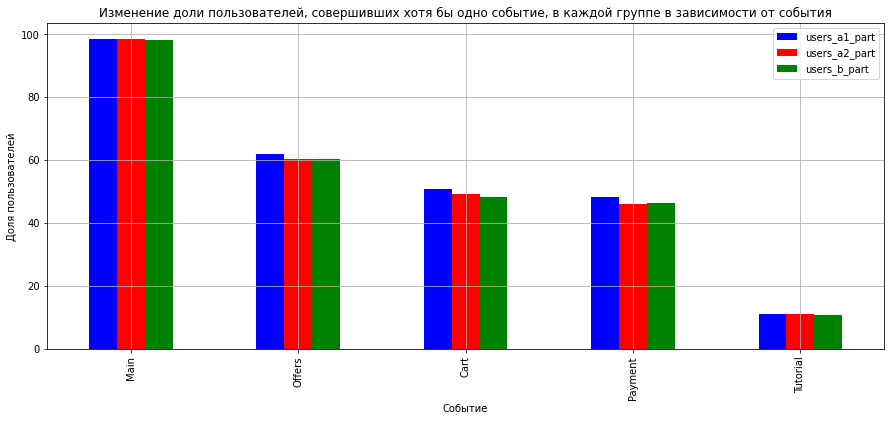

In [41]:
# визуализация отдельно по группам
events_by_users.plot(x='event_short',
                     y=['users_a1_part', 'users_a2_part', 'users_b_part'],
                     kind='bar',
                     figsize=(15,6),
                     grid=True,
                     color = ['blue', 'red', 'green'],
                     title = 'Изменение доли пользователей, совершивших хотя бы одно событие, в каждой группе в зависимости от события',
                    legend=True)
plt.xlabel('Событие')
plt.ylabel('Доля пользователей')
plt.show()

С долями от общего числа пользователей картина практически идентична той, что представлена просто для общего числа пользователей и с разбиением по группам.

Таким образом события действительно расположены в следующем порядке: 

1. **MainScreenAppear** - появление главного экрана;
2. **OffersScreenAppear** - появление экрана с предложениями;
3. **CartScreenAppear** - появление экрана с корзиной;
4. **PaymentScreenSuccessful** - экран с подтверждением успешной покупки.

Как говорилось до этого, событие **Tutorial** в контексте изучения воронки событий не несет полезной информации.

Следует также обратить внимание на то, что на первом этапе мы имеем не 100 % пользователей. Это может быть связано с тем, что мы "отрезали" данные за июль, и пользователи могли начать работать с приложением как раз в этот период времени. Однако, как мы выяснили на предыдущем шаге, "обрезка" в целом мало повлияла на весь набор данных.

Теперь можно перейти к более подробному изучению воронки событий.

Для начала определим, какая доля пользователей проходит на последующий шаг воронки. Событие **Tutorial** анализировать не будем, поскольку к руководству (или инструкции) пользователь мог перейти на любом шаге. 

Поэтому воронка будет выглядеть следующим образом:

**MainScreenAppear** --> **OffersScreenAppear** --> **CartScreenAppear** --> **PaymentScreenSuccessful**

Из таблицы "events_by_users" оставим только те строки и столбцы, которые нам потребуются для построения воронки:

In [42]:
small_table = events_by_users.loc[:3, ['event', 'total_part','users_a1_part','users_a2_part', 'users_b_part']]
small_table

,event,total_part,users_a1_part,users_a2_part,users_b_part
0,MainScreenAppear,98.47,98.63,98.53,98.27
1,OffersScreenAppear,60.96,62.08,60.49,60.35
2,CartScreenAppear,49.56,50.97,49.26,48.48
3,PaymentScreenSuccessful,46.97,48.31,46.08,46.55


In [43]:
step = small_table['total_part'][0]
step_a1 = small_table['users_a1_part'][0]
step_a2 = small_table['users_a2_part'][0]
step_b = small_table['users_b_part'][0]

for i in small_table.index:
    small_table.loc[i:,'ratio_total'] = (small_table['total_part'][i]/step*100).round(2)
    step = small_table['total_part'][i]
    small_table.loc[i:,'ratio_a1'] = (small_table['users_a1_part'][i]/step_a1*100).round(2)
    step_a1 = small_table['users_a1_part'][i]
    small_table.loc[i:,'ratio_a2'] = (small_table['users_a2_part'][i]/step_a2*100).round(2)
    step_a2 = small_table['users_a1_part'][i]
    small_table.loc[i:,'ratio_b'] = (small_table['users_b_part'][i]/step_b*100).round(2)
    step_b = small_table['users_b_part'][i]
small_table

,event,total_part,users_a1_part,users_a2_part,users_b_part,ratio_total,ratio_a1,ratio_a2,ratio_b
0,MainScreenAppear,98.47,98.63,98.53,98.27,100.00,100.00,100.00,100.00
1,OffersScreenAppear,60.96,62.08,60.49,60.35,61.91,62.94,61.33,61.41
2,CartScreenAppear,49.56,50.97,49.26,48.48,81.30,82.10,79.35,80.33
3,PaymentScreenSuccessful,46.97,48.31,46.08,46.55,94.77,94.78,90.41,96.02


Как видно из данной таблицы, больше всего пользователей теряется при переходе от **Главного экрана** к **Экрану с предложениями** (примерно 38 % от числа пользователей). При переходе от **Экрана с предложениями** к **Окну корзины** теряется примерно 19 % пользователей по сравнению с предыдущим шагом. Ну а меньше всего пользователей потерялось при переходе к **Окну с успешной оплатой** - примерно 5 %. 

Данный вывод относится к общему числу пользователей без разделения на группы. Если учитывать разделение на 3 группы, то отличия имеются только в процентном отношении, но качественно "потери" при переходах аналогичные.

Осталось выяснить, какая доля пользователей проходит весь путь от **Главного экрана** до **Окна с успешной оплатой**. 

В таблице выше видно, что в среднем (без разделения на 3 группы) до конца проходят примерно 47 % пользователей. Однако, здесь не учтено, что пользователь мог пропустить какие-либо этапы (это возможно, например, при переходе через сторонние сервисы сразу к странице с товаром или при переходе с главной страницы сразу к оплате товара, минуя экран с предложениями).

Поэтому для построения воронки вновь воспользуемся таблицей "data_clear", исключив из нее событие **"tutorial"**, и отберем из нее только тех пользователей, которые переходили последовательно от первого этапа ко второму, от второго к третьему и от третьего к четвертому.

Итоговый результат приведем как для общего числа пользователей, так и для разделенного на 3 группы.

In [44]:
level_0 = data_clear.loc[data_clear['event']!='Tutorial'].pivot_table(
        index='user_id', 
        columns='event', 
        values='dt',
        aggfunc='min').reset_index(drop=True)
level_0

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,NaT,2019-08-06 14:06:34,NaT,NaT
1,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
2,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
3,NaT,2019-08-05 08:06:34,NaT,NaT
4,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...
7525,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57
7526,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16
7527,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT
7528,NaT,2019-08-01 17:30:27,NaT,NaT


На первом этапе мы избавились от события "**Tutorial**" и сгруппировали данные по времени событий, совершенными уникальными пользователями (агрегировали по минимальному времени, чтобы отследить действия пользователя с первого совершения события). Теперь можно пройти последовательно по каждому событию.

In [45]:
level_1 = (~level_0['MainScreenAppear'].isna())
level_2 = level_1 & (level_0['OffersScreenAppear'] > level_0['MainScreenAppear'])
level_3 = level_2 & (level_0['CartScreenAppear'] > level_0['OffersScreenAppear'])
level_4 = level_3 & (level_0['PaymentScreenSuccessful'] > level_0['CartScreenAppear'])

main_screen_count = level_0[level_1].shape[0]
offers_screen_count = level_0[level_2].shape[0]
cart_screen_count = level_0[level_3].shape[0]
pay_count = level_0[level_4].shape[0]

funnel = pd.DataFrame(columns = ['event', 'number_of_users'], data = [
    ['MainScreenAppear', main_screen_count],
    ['OffersScreenAppear', offers_screen_count],
    ['CartScreenAppear', cart_screen_count],
    ['PaymentScreenSuccessful', pay_count]])

step_f = funnel['number_of_users'][0]
start = step_f
for i in funnel.index:
    funnel.loc[i,'ratio_from_start'] = (funnel['number_of_users'][i]/start*100).round(2)
    step_f = funnel['number_of_users'][i]
    
funnel

,event,number_of_users,ratio_from_start
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4201,56.62
2,CartScreenAppear,1767,23.82
3,PaymentScreenSuccessful,454,6.12


Таким образом, с главной страницы до успешной оплаты дошли только 454 пользователя из 7419, что составляет **6.12 %**.

Теперь посмотрим, какая ситуация с учетом разбиения по 3 группам. Повторим шаги, сделанные выше.

In [46]:
level_0_a1 = data_clear.loc[(data_clear['event']!='Tutorial') & (data_clear['group']==246)].pivot_table(
        index='user_id', 
        columns='event', 
        values='dt',
        aggfunc='min').reset_index(drop=True)

level_1_a1 = (~level_0_a1['MainScreenAppear'].isna())
level_2_a1 = level_1_a1 & (level_0_a1['OffersScreenAppear'] > level_0_a1['MainScreenAppear'])
level_3_a1 = level_2_a1 & (level_0_a1['CartScreenAppear'] > level_0_a1['OffersScreenAppear'])
level_4_a1 = level_3_a1 & (level_0_a1['PaymentScreenSuccessful'] > level_0_a1['CartScreenAppear'])

main_screen_count_a1 = level_0_a1[level_1_a1].shape[0]
offers_screen_count_a1 = level_0_a1[level_2_a1].shape[0]
cart_screen_count_a1 = level_0_a1[level_3_a1].shape[0]
pay_count_a1 = level_0_a1[level_4_a1].shape[0]

level_0_a2 = data_clear.loc[(data_clear['event']!='Tutorial') & (data_clear['group']==247)].pivot_table(
        index='user_id', 
        columns='event', 
        values='dt',
        aggfunc='min').reset_index(drop=True)

level_1_a2 = (~level_0_a2['MainScreenAppear'].isna())
level_2_a2 = level_1_a2 & (level_0_a2['OffersScreenAppear'] > level_0_a2['MainScreenAppear'])
level_3_a2 = level_2_a2 & (level_0_a2['CartScreenAppear'] > level_0_a2['OffersScreenAppear'])
level_4_a2 = level_3_a2 & (level_0_a2['PaymentScreenSuccessful'] > level_0_a2['CartScreenAppear'])

main_screen_count_a2 = level_0_a2[level_1_a2].shape[0]
offers_screen_count_a2 = level_0_a2[level_2_a2].shape[0]
cart_screen_count_a2 = level_0_a2[level_3_a2].shape[0]
pay_count_a2 = level_0_a2[level_4_a2].shape[0]

level_0_b = data_clear.loc[(data_clear['event']!='Tutorial') & (data_clear['group']==248)].pivot_table(
        index='user_id', 
        columns='event', 
        values='dt',
        aggfunc='min').reset_index(drop=True)

level_1_b = (~level_0_b['MainScreenAppear'].isna())
level_2_b = level_1_b & (level_0_b['OffersScreenAppear'] > level_0_b['MainScreenAppear'])
level_3_b = level_2_b & (level_0_b['CartScreenAppear'] > level_0_b['OffersScreenAppear'])
level_4_b = level_3_b & (level_0_b['PaymentScreenSuccessful'] > level_0_b['CartScreenAppear'])

main_screen_count_b = level_0_b[level_1_b].shape[0]
offers_screen_count_b = level_0_b[level_2_b].shape[0]
cart_screen_count_b = level_0_b[level_3_b].shape[0]
pay_count_b = level_0_b[level_4_b].shape[0]

funnel_a1 = pd.DataFrame(columns = ['event', 'number_of_users_a1'], data = [
    ['MainScreenAppear', main_screen_count_a1],
    ['OffersScreenAppear', offers_screen_count_a1],
    ['CartScreenAppear', cart_screen_count_a1],
    ['PaymentScreenSuccessful', pay_count_a1]])

funnel_a2 = pd.DataFrame(columns = ['event', 'number_of_users_a2'], data = [
    ['MainScreenAppear', main_screen_count_a2],
    ['OffersScreenAppear', offers_screen_count_a2],
    ['CartScreenAppear', cart_screen_count_a2],
    ['PaymentScreenSuccessful', pay_count_a2]])

funnel_b = pd.DataFrame(columns = ['event', 'number_of_users_b'], data = [
    ['MainScreenAppear', main_screen_count_b],
    ['OffersScreenAppear', offers_screen_count_b],
    ['CartScreenAppear', cart_screen_count_b],
    ['PaymentScreenSuccessful', pay_count_b]])

step_a1 = funnel_a1['number_of_users_a1'][0]
start_a1 = step_a1
step_a2 = funnel_a2['number_of_users_a2'][0]
start_a2 = step_a2
step_b = funnel_b['number_of_users_b'][0]
start_b = step_b

for i in funnel_a1.index:
    funnel_a1.loc[i,'ratio_from_start_a1'] = (funnel_a1['number_of_users_a1'][i]/start_a1*100).round(2)
    step_a1= funnel_a1['number_of_users_a1'][i]
    funnel_a2.loc[i,'ratio_from_start_a2'] = (funnel_a2['number_of_users_a2'][i]/start_a2*100).round(2)
    step_a2= funnel_a2['number_of_users_a2'][i]
    funnel_b.loc[i,'ratio_from_start_b'] = (funnel_b['number_of_users_b'][i]/start_b*100).round(2)
    step_b= funnel_b['number_of_users_b'][i]

funnel_a1_a2_b = (funnel_a1.merge(funnel_a2, left_on='event', right_on='event', how='left').
                           merge(funnel_b, left_on='event', right_on='event', how='left'))

funnel_a1_a2_b

,event,number_of_users_a1,ratio_from_start_a1,number_of_users_a2,ratio_from_start_a2,number_of_users_b,ratio_from_start_b
0,MainScreenAppear,2450,100.00,2476,100.00,2493,100.00
1,OffersScreenAppear,1411,57.59,1379,55.69,1411,56.60
2,CartScreenAppear,584,23.84,600,24.23,583,23.39
3,PaymentScreenSuccessful,145,5.92,144,5.82,165,6.62


Как видно по полученной таблице, и при разбиении на 3 группы от главной страницы до страницы с успешной оплатой также доходят в среднем около 6 % пользователей.

**Вывод по шагу 3.**

По данному шагу можно сделать следующие выводы:

1. В логе присутствуют следующие события: 
    * **MainScreenAppear** (появление главного экрана) - **самое частое** (117328 появлений или 48.71 % от всех событий);
    * **OffersScreenAppear** (появление экрана с предложениями);
    * **CartScreenAppear** (появление экрана с корзиной);
    * **PaymentScreenSuccessful** (экран с подтверждением успешной покупки);
    * **Tutorial** (руководство либо инструкция для пользователя) - **не влияющее на эксперимент**.
2. **7419** пользователей попали на главный экран.
3. Цепочка событий выглядит следующим образом: 

**MainScreenAppear** --> **OffersScreenAppear** --> **CartScreenAppear** --> **PaymentScreenSuccessful**

4. Больше всего пользователей теряется при переходе с главного экрана к странице с предложениями (более 38 %).
5. Всего **около 6 %** пользователей проходят полностью путь от попадания на главный экран до успешной оплаты.
6. При разбиении на 3 группы результаты качественно совпадают с теми, которые представлены для всего набора данных.
7. **Без учета строгой последовательности прохождения событий до оплаты дошло 47 % пользователей.**

## Шаг 4. Исследование результатов эксперимента

На данном шаге нам предстоит провести A/A/B-эксперимент. Для этого будет сделано следующее:
* проведен A/A-эксперимент, чтобы проверить корректность всех механизмов и расчетов;
* проверено отличие между контрольными группами по самому популярному событию ("появление главного экрана");
* проверено отличие между экспериментальной и контрольными группами (по отдельности и вместе);
* сформулируем окончательные выводы.

Снова выведем, сколько пользователей в каждой группе, только представим их в виде таблицы (она нам пригодится для проведения теста) и добавим новый столбец с суммарным количеством пользователей из групп 246 и 247:

In [47]:
groups = data_clear.groupby('group')['user_id'].nunique()
groups['246+247'] = groups[246] + groups[247]
groups

group
246        2484
247        2513
248        2537
246+247    4997
Name: user_id, dtype: int64

На предыдущем шаге было определено, что самое популярное событие - **MainScreenAppear**. Его совершили более 98 % пользователей (как в общем, так и при разбиении по группам).

В таблице "events_by_users" можно увидеть доли пользователей, совершивших определенные события:

In [48]:
events_by_users

,event,total_users,users_a1,users_a2,users_b,event_short,total_part,users_a1_part,users_a2_part,users_b_part
0,MainScreenAppear,7419,2450,2476,2493,Main,98.47,98.63,98.53,98.27
1,OffersScreenAppear,4593,1542,1520,1531,Offers,60.96,62.08,60.49,60.35
2,CartScreenAppear,3734,1266,1238,1230,Cart,49.56,50.97,49.26,48.48
3,PaymentScreenSuccessful,3539,1200,1158,1181,Payment,46.97,48.31,46.08,46.55
4,Tutorial,840,278,283,279,Tutorial,11.15,11.19,11.26,11.00


Создадим таблицу для проведения теста (оставим только события, за исключением "Tutorial" и распределение пользователей по группам):

In [49]:
group_test = data_clear[data_clear['event']!='Tutorial'].pivot_table(index='event',columns='group',values='user_id',aggfunc='nunique').sort_values(by=246, ascending=False)

group_test = group_test.reset_index()
group_test['246+247'] = group_test[246] + group_test[247]
group_test['total'] = group_test['246+247'] + group_test[248]

group_test

group,event,246,247,248,246+247,total
0,MainScreenAppear,2450,2476,2493,4926,7419
1,OffersScreenAppear,1542,1520,1531,3062,4593
2,CartScreenAppear,1266,1238,1230,2504,3734
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539


Перед проведением A/B-теста нужно убедиться, что:
1. Количество пользователей, попавших в различные группы, отличается примерно на 0.5% (отличие немного больше, но это не критично);
2. Данные во всех группах отправляются в системы аналитики одинаково;
3. Различие ключевых метрик по группам не более 1% и не имеет статистической значимости;
4. Каждый посетитель, попавший в одну из групп теста, остаётся в этой группе до конца теста.

Из всех указанных пунктов нужно подтвердить только пункт № 3. Для этого проведем A/A-тест.

Напишем функцию для проверки статистической разницы между выборками:

Сформулируем нулевую и альтернативную гипотезы:
* **H0 - между группами нет значимой разницы**
* **H1 - между группами есть значимая разница**

In [50]:
def test(gr1, gr2, alpha):
    for i in group_test.index:
        # пропорция успехов в первой группе:
        p1 = group_test[gr1][i]/groups[gr1]
        # пропорция успехов во второй группе:
        p2 = group_test[gr2][i]/groups[gr2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((group_test[gr1][i]+group_test[gr2][i])/(groups[gr1]+groups[gr2]))
        #разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/groups[gr1]+1/groups[gr2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('Для {} p-значение равно {}'.format(group_test['event'][i], p_value))
        if (p_value < alpha):
            print('Отвергаем нулевую гипотезу: между группами пользователей есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы')
        print('')
        
test(246, 247, 0.01)

Для MainScreenAppear p-значение равно 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для OffersScreenAppear p-значение равно 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для CartScreenAppear p-значение равно 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для PaymentScreenSuccessful p-значение равно 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы



A/A-тест успешно пройден. Группы 246 и 247 по всем событиям не имеют статистической разницы.

Поэтому можно теперь провести A/B-тесты для следующих комбинаций групп:
* 246/248;
* 247/248;
* 246+247/248.

Только теперь уровень значимости **alpha** примем равным 5 %

In [51]:
test(246, 248, 0.05)

Для MainScreenAppear p-значение равно 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для OffersScreenAppear p-значение равно 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для CartScreenAppear p-значение равно 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для PaymentScreenSuccessful p-значение равно 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы



In [52]:
test(247, 248, 0.05)

Для MainScreenAppear p-значение равно 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для OffersScreenAppear p-значение равно 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для CartScreenAppear p-значение равно 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для PaymentScreenSuccessful p-значение равно 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы



In [53]:
test('246+247', 248, 0.05)

Для MainScreenAppear p-значение равно 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для OffersScreenAppear p-значение равно 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для CartScreenAppear p-значение равно 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы

Для PaymentScreenSuccessful p-значение равно 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу: между группами нет значимой разницы



В итоге проверено 16 статистических гипотез, и все они подтвердили, что между исследуемыми группами нет значимой разницы.

Таким образом, изменение шрифта в приложении **практически никак не повлияло** на количество пользователей.

## Общий вывод

В ходе исследования было сделано и выявлено следующее:

1. Произведена предобработка датасета.


2. Подробно изучен лог данных:
    * представлены данные с 25 июля по 7 августа 2019 года, однако основные события происходили с 1 августа 2019 года, поэтому было решено не учитывать данные за более ранний период времени (было потеряно всего 1.16 % событий и примерно 0.23 % уникальных пользователей);
    * в логе 5 уникальных событий, которые идут в следующем порядке:
        
        **MainScreenAppear** --> **OffersScreenAppear** --> **CartScreenAppear** --> **PaymentScreenSuccessful**,
        
        а **Tutorial** может произойти в любой момент времени и при этом явно не влияет на прохождение воронки (поэтому при изучении воронки мы его не учитывали);
    * в логе всего 7551 уникальный пользователь, которые разбиты на примерно равные 3 группы - 246, 247, 248. В среднем около 32 событий на одного пользователя;
    * **MainScreenAppear** (появление главного экрана) - **самое частое** событие (**117328 появлений** или **48.71 %** от числа всех событий, которые совершили **7419 пользователей**).
    
    
3. Изучена воронка событий:
    * больше всего пользователей теряется при переходе с главного экрана к странице с предложениями (более 38 %);
    * **около 6 %** пользователей проходят полностью путь от попадания на главный экран до успешной оплаты.
    
    
4. По результатам A/A/B-теста определено, что изменение шрифта в приложении практически не повлияло на количество пользователей.